内核网址：https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

这一部分是模型预测。$0.41503$。

In [1]:
%%time
import pandas as pd

data_train = pd.read_csv("../input/train.csv")
data_test = pd.read_csv("../input/test.csv")

CPU times: user 182 ms, sys: 35 ms, total: 217 ms
Wall time: 222 ms


In [2]:
data_train.shape[0] + data_test.shape[0]

17379

In [3]:
# sort 表示先对字段名进行排序，这里我们现在不需要
data = pd.concat([data_train, data_test], sort=False, axis=0)
# data = data_train.append(data_test, sort=False)
data.head()
# data.reset_index(inplace=True)
# data.drop('index', inplace=True, axis=1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [4]:
from datetime import datetime

# datetime 是一个字段名
data['date'] = data.datetime.apply(lambda x: x.split()[0])
data['hour'] = data.datetime.apply(
    lambda x: x.split()[1].split(':')[0]).astype('int')
data['year'] = data.datetime.apply(lambda x: x.split()[0].split('-')[0])

data['weekday'] = data.date.apply(
    lambda dateString: datetime.strptime(dateString, '%Y-%m-%d').weekday())
data['month'] = data.date.apply(
    lambda dateString: datetime.strptime(dateString, '%Y-%m-%d').month)

In [5]:
# 最后 5 列是新加的
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,0,2011,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,1,2011,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2,2011,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,3,2011,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,4,2011,5,1


直观看缺失值的位置。

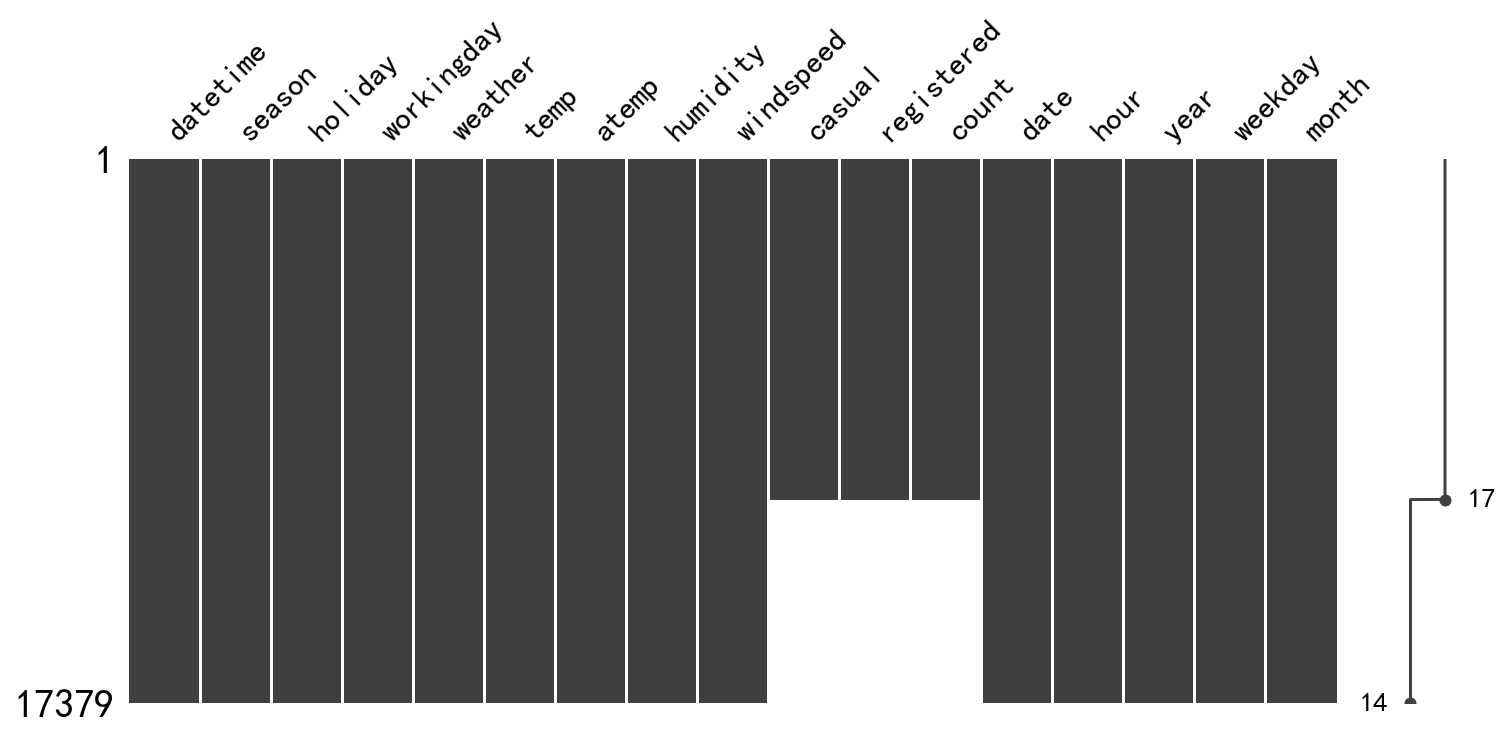

In [6]:
import missingno as msno

msno.matrix(data, figsize=(12, 5))
plt.show()

`windspeed` 这个字段有点特别，如果值是 $0$ 表示异常值。

In [7]:
data_windspeed_zero = data[data['windspeed'] == 0]
data_windspeed_not_zero = data[data['windspeed'] != 0]

In [8]:
# 选连续型变量作为随机森林模型的特征

windspeed_columns = [
    'season',
    'weather',
    'temp',
    'atemp',
    'humidity',
    'year',
    'month',
]

In [9]:
from sklearn.ensemble import RandomForestRegressor

rfr_windspeed = RandomForestRegressor(n_estimators=100)
rfr_windspeed.fit(data_windspeed_not_zero[windspeed_columns],
                  data_windspeed_not_zero['windspeed'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [10]:
windspeed_pred = rfr_windspeed.predict(data_windspeed_zero[windspeed_columns])
windspeed_pred

array([ 6.72467275,  6.362789  ,  6.362789  , ...,  7.31585283,
       27.060563  ,  6.76400957])

In [11]:
data.loc[data['windspeed'] == 0, 'windspeed'] = windspeed_pred

## 类别变量转换

In [12]:
categorical_feature_names = [
    'season', 'holiday', 'workingday', 'weather', 'weekday', 'month', 'year',
    'hour'
]

for var in categorical_feature_names:
    data[var] = data[var].astype('category')

In [13]:
numerical_feature_names = ['temp', 'humidity', 'windspeed', 'atemp']


分离训练数据与测试数据。

In [14]:
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,6.724673,3.0,13.0,16.0,2011-01-01,0,2011,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,6.362789,8.0,32.0,40.0,2011-01-01,1,2011,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,6.362789,5.0,27.0,32.0,2011-01-01,2,2011,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.471236,3.0,10.0,13.0,2011-01-01,3,2011,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.471236,0.0,1.0,1.0,2011-01-01,4,2011,5,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.003200,0.0,1.0,1.0,2011-01-01,5,2011,5,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,6.362789,2.0,0.0,2.0,2011-01-01,6,2011,5,1
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,6.433802,1.0,2.0,3.0,2011-01-01,7,2011,5,1
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,6.471236,1.0,7.0,8.0,2011-01-01,8,2011,5,1
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,9.214954,8.0,6.0,14.0,2011-01-01,9,2011,5,1


In [15]:
data_train = data[data['count'].notnull()]
data_test = data[data['count'].isnull()]

In [16]:
datetime_col = data_test['datetime']

y_lables_casual = data_train['casual']
y_lables_registered = data_train['registered']
y_labels = data_train['count']

In [17]:
drop_features = ['casual', 'count', 'datetime', 'date', 'registered']

data_train.drop(drop_features, axis=1, inplace=True)
# data_test.drop(drop_features, axis=1, inplace=True)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


$$
\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$

In [18]:
def rmsle(y, y_, convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2)**2
    return np.sqrt(np.mean(calc))

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_labels_log1p = np.log1p(y_labels)
lr_model = LinearRegression()
lr_model.fit(data_train, y_labels_log1p)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
y_preds = lr_model.predict(data_train)

In [21]:
rmsle(np.exp(y_labels_log1p), np.exp(y_preds), False)

0.9779721577671625

## Ridge

In [22]:
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
ridge_params = {
    'max_iter': [3000],
    'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]
}

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
ridge_grid_model = GridSearchCV(
    ridge,
    ridge_params,
    scoring=rmsle_scorer,
    cv=5,
    verbose=1,
    return_train_score=True)

ridge_grid_model.fit(data_train, y_labels_log1p)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    3.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [3000], 'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=1)

In [23]:
ridge_grid_preds = ridge_grid_model.best_estimator_.predict(data_train)
ridge_grid_preds

array([2.22700488, 2.30490202, 2.40313011, ..., 5.74514201, 5.85136834,
       5.86005332])

In [24]:
ridge_grid_model.best_params_

{'alpha': 0.1, 'max_iter': 3000}

In [25]:
rmsle(np.exp(y_labels_log1p), np.exp(ridge_grid_preds), False)

0.977972142701735

In [26]:
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
# 设置 value 的显示长度为 100，默认为 50
pd.set_option('max_colwidth', 100)

In [27]:
df = pd.DataFrame(ridge_grid_model.cv_results_)
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_max_iter', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

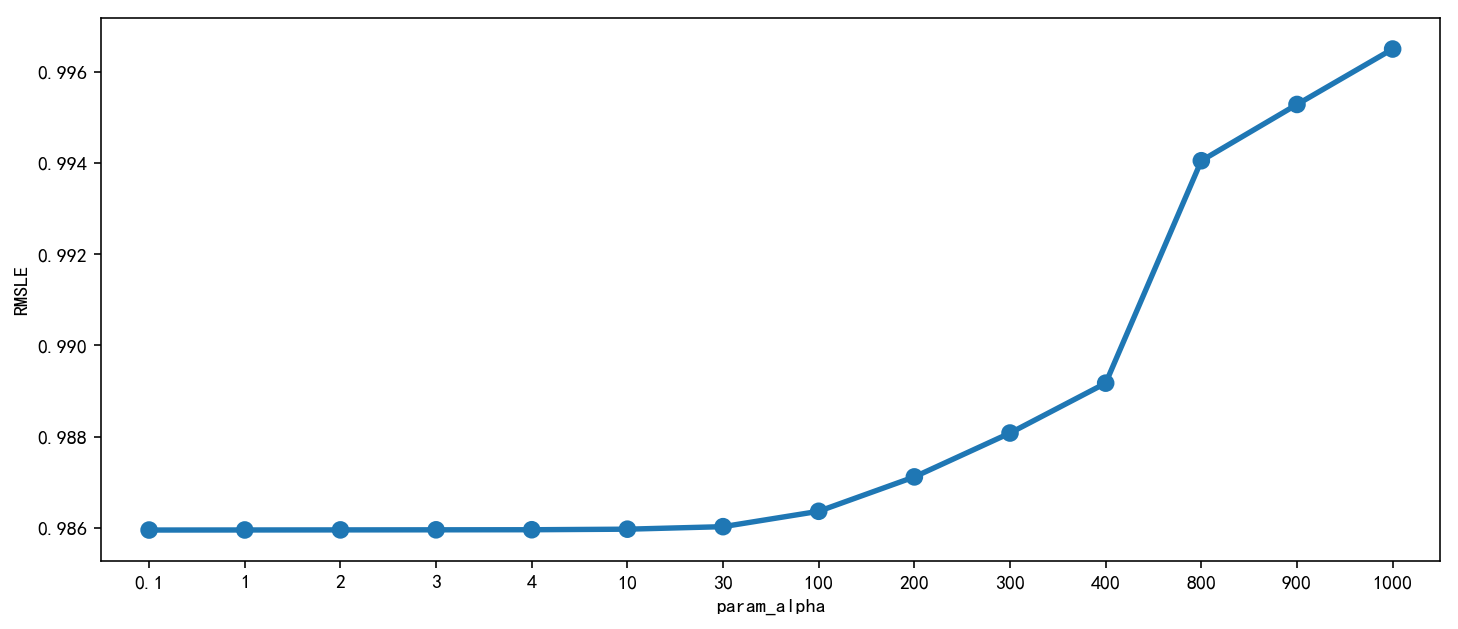

In [28]:
import seaborn as sns

df['RMSLE'] = -df['mean_test_score']

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

sns.pointplot(data=df, x='param_alpha', y='RMSLE', ax=ax)
plt.show()

In [29]:
ridge_grid_model.best_params_

{'alpha': 0.1, 'max_iter': 3000}

## Lasso

In [30]:
alpha = 1 / np.array(
    [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter': [3000], 'alpha': alpha}

In [31]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso_grid_model = GridSearchCV(
    lasso, lasso_params, scoring=rmsle_scorer, cv=5, return_train_score=True)

In [32]:
lasso_grid_model.fit(data_train, y_labels_log1p)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [3000], 'alpha': array([1.00000e+01, 1.00000e+00, 5.00000e-01, 3.33333e-01, 2.50000e-01,
       1.00000e-01, 3.33333e-02, 1.00000e-02, 5.00000e-03, 3.33333e-03,
       2.50000e-03, 1.25000e-03, 1.11111e-03, 1.00000e-03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

In [33]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

alpha

array([10.   ,  1.   ,  0.5  ,  0.333,  0.25 ,  0.1  ,  0.033,  0.01 ,
        0.005,  0.003,  0.003,  0.001,  0.001,  0.001])

In [34]:
lasso_grid_model.best_params_

{'alpha': 0.005, 'max_iter': 3000}

In [35]:
y_preds = lasso_grid_model.best_estimator_.predict(data_train)
rmsle(np.exp(y_labels_log1p), np.exp(y_preds), False)

0.9781090820785535

In [36]:
df = pd.DataFrame(lasso_grid_model.cv_results_)
df['RMSLE'] = df['mean_test_score'].apply(lambda x: -x)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,RMSLE
0,0.013930,0.002207,0.009432,0.001116,10,3000,"{'alpha': 10.0, 'max_iter': 3000}",-1.502988,-1.276442,-1.347355,-1.446781,-1.412056,-1.397134,0.078663,14,-1.341636,-1.391280,-1.374092,-1.354681,-1.363488,-1.365035,0.016899,1.397134
1,0.016440,0.002252,0.009930,0.001325,1,3000,"{'alpha': 1.0, 'max_iter': 3000}",-1.220851,-0.950318,-1.033158,-1.028853,-1.126555,-1.071961,0.093076,13,-1.009849,-1.045114,-1.026561,-1.033362,-1.010821,-1.025141,0.013472,1.071961
2,0.017929,0.002597,0.009083,0.000779,0.5,3000,"{'alpha': 0.5, 'max_iter': 3000}",-1.186543,-0.956661,-1.034689,-1.028391,-1.120362,-1.065340,0.079796,11,-0.999978,-1.023214,-0.998888,-1.004552,-1.001933,-1.005713,0.008960,1.065340
3,0.020472,0.003214,0.010494,0.001456,0.333333,3000,"{'alpha': 0.3333333333333333, 'max_iter': 3000}",-1.173667,-0.961853,-1.047847,-1.031720,-1.119570,-1.066941,0.073228,12,-0.997954,-1.017223,-0.990244,-0.998465,-1.000570,-1.000891,0.008885,1.066941
4,0.018649,0.002301,0.008369,0.000181,0.25,3000,"{'alpha': 0.25, 'max_iter': 3000}",-1.150902,-0.965054,-1.057462,-1.033891,-1.117882,-1.065046,0.065101,10,-0.995154,-1.015233,-0.987317,-0.996430,-1.000051,-0.998837,0.009191,1.065046
5,0.021526,0.001922,0.009004,0.000691,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.114169,-0.971805,-1.079750,-1.036597,-1.082464,-1.056962,0.049212,9,-0.991976,-1.013355,-0.983580,-0.993326,-0.997403,-0.995928,0.009805,1.056962
6,0.021420,0.001212,0.008849,0.000822,0.0333333,3000,"{'alpha': 0.03333333333333333, 'max_iter': 3000}",-1.029857,-0.915761,-1.041553,-1.006548,-0.997606,-0.998268,0.044153,8,-0.978832,-0.998670,-0.967546,-0.973704,-0.981912,-0.980133,0.010471,0.998268
7,0.020039,0.000415,0.008760,0.000799,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003415,-0.904590,-1.033530,-1.005274,-0.979057,-0.985175,0.043830,4,-0.975913,-0.996316,-0.965379,-0.971555,-0.979016,-0.977636,0.010402,0.985175
8,0.029114,0.012983,0.008925,0.000982,0.005,3000,"{'alpha': 0.005, 'max_iter': 3000}",-1.000635,-0.903632,-1.032482,-1.006800,-0.979125,-0.984536,0.043881,1,-0.975625,-0.996137,-0.965246,-0.971301,-0.978640,-0.977390,0.010399,0.984536
9,0.030426,0.016683,0.008935,0.000823,0.00333333,3000,"{'alpha': 0.0033333333333333335, 'max_iter': 3000}",-1.000315,-0.903832,-1.032234,-1.007704,-0.979715,-0.984762,0.043809,2,-0.975388,-0.995989,-0.965185,-0.971240,-0.978478,-0.977256,0.010371,0.984762


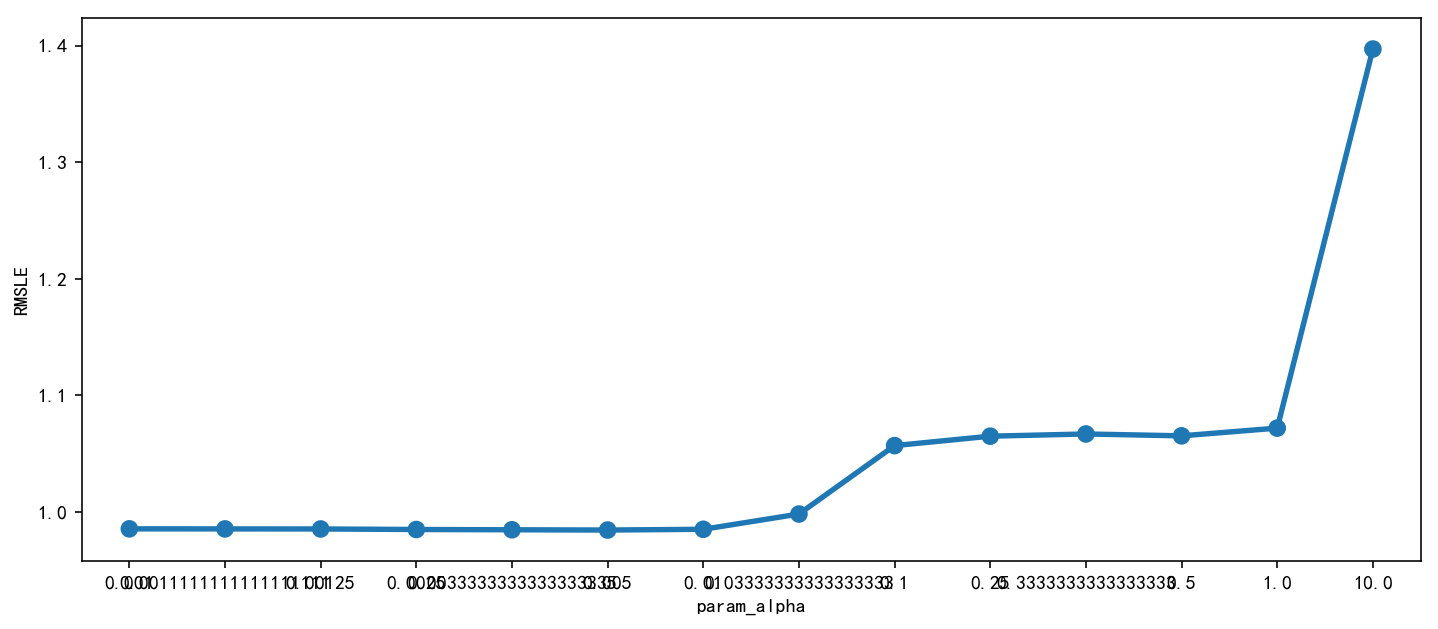

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

sns.pointplot(data=df, x='param_alpha', y='RMSLE', ax=ax)
plt.show()

In [38]:
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor(n_estimators=100)
rfr_model.fit(data_train, y_labels_log1p)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
y_pred = rfr_model.predict(data_train)
rmsle(np.exp(y_labels_log1p),np.exp(y_pred),False)

0.10232973355564241

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=4000, alpha=0.01)

gbr.fit(data_train, y_labels_log1p)

GradientBoostingRegressor(alpha=0.01, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=4000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
y_pred = gbr.predict(data_train)
rmsle(np.exp(y_labels_log1p), np.exp(y_pred), False)

0.1891318213770932

In [42]:
data_test.drop(
    ['datetime', 'casual', 'registered', 'count', 'date'],
    axis=1,
    inplace=True)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
data_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,year,weekday,month
0,1,0,1,1,10.66,11.365,56,26.002700,0,2011,3,1
1,1,0,1,1,10.66,13.635,56,8.695615,1,2011,3,1
2,1,0,1,1,10.66,13.635,56,8.695615,2,2011,3,1
3,1,0,1,1,10.66,12.880,56,11.001400,3,2011,3,1
4,1,0,1,1,10.66,12.880,56,11.001400,4,2011,3,1


In [44]:
y_pred_test = gbr.predict(data_test)

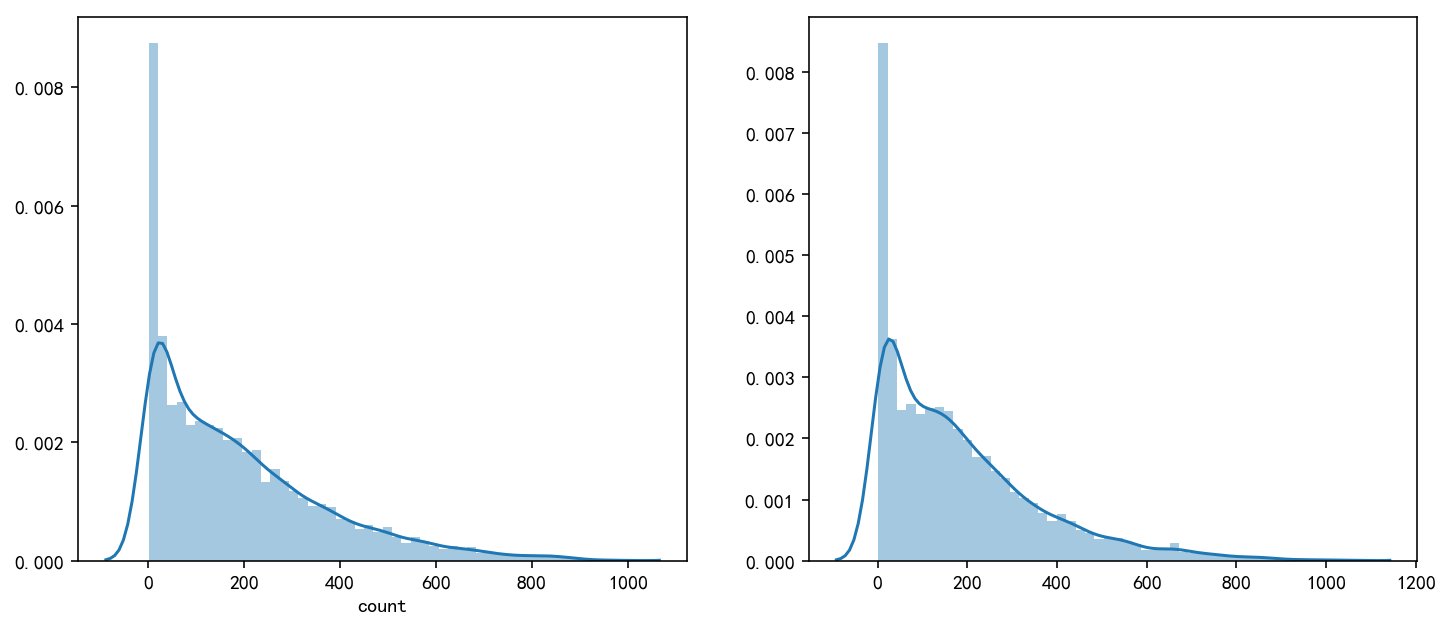

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_labels, ax=ax1, bins=50)
sns.distplot(np.exp(y_pred_test), ax=ax2, bins=50)
plt.show()

In [46]:
submission = pd.DataFrame({
    "datetime":
    datetime_col,
    "count": [max(0, x) for x in np.expm1(y_pred_test)]
})

In [47]:
submission.to_csv(
    '../output/bike_predictions_gbm_separate_without_fe.csv', index=False)